<a href="https://colab.research.google.com/github/NeuralNetGeek/monkeypox-diagnosis/blob/main/Monkey_Pox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

DATA COLLECTION

The dataset was sourced from https://www.kaggle.com/datasets/muhammad4hmed/monkeypox-patients-dataset

DATA CLEANING, EXPLORATION AND PREPROCESSING

In [2]:
cols = ['Patient_ID', 'Systemic Illness', 'Rectal Pain', 'Sore Throat', 'Penile Oedema', 'Oral Lesions', 'Solitary Lesion', 'Swollen Tonsils', 'HIV Infection', 'Sexually Transmitted Infection', 'MonkeyPox']
df = pd.read_csv('monkey.data.csv')
df.columns = cols
df.drop(['Patient_ID', 'Systemic Illness'], axis=1, inplace=True)

df['Genital Symptoms'] = df[['Rectal Pain', 'Penile Oedema']].max(axis=1)

features = ['Genital Symptoms', 'Oral Lesions', 'Sore Throat', 'Swollen Tonsils', 'Solitary Lesion', 'HIV Infection']
df[features] = df[features].astype(int)

df['Monkey Pox'] = df['MonkeyPox'].map({'Positive': 1, 'Negative': 0})
df = df.drop(['Rectal Pain', 'Penile Oedema', 'Sexually Transmitted Infection', 'MonkeyPox'], axis=1)

df.head()

,Sore Throat,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Genital Symptoms,Monkey Pox
0,1,1,0,1,0,1,0
1,0,1,0,0,1,1,1
2,1,0,0,0,1,1,1
3,0,0,1,1,1,1,1
4,1,0,0,1,1,1,1


In [3]:
df['Monkey Pox'].value_counts()

,count
Monkey Pox,
1,15909
0,9091


In [4]:
features_encoded = ['Genital Symptoms', 'Oral Lesions', 'Sore Throat', 'Swollen Tonsils', 'Solitary Lesion', 'HIV Infection']
target = 'Monkey Pox'


X = df[features_encoded]
y = df[target]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.3, stratify=y_temp, random_state=42)

smote = SMOTETomek(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

TRAIN, VALID AND TEST

In [5]:
def evaluate_classifiers(models, X_scaled, y, show_reports=True, show_confusion=True):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    summary = []

    for name, model in models.items():
        try:
            cv_scores = cross_validate(model, X_scaled, y, cv=skf, scoring='f1')
            mean_cv_score = cv_scores['test_score'].mean()

            model.fit(X_scaled, y)
            y_pred = model.predict(X_scaled)

            acc = accuracy_score(y, y_pred)
            prec = precision_score(y, y_pred, zero_division=0)
            rec = recall_score(y, y_pred, zero_division=0)
            f1 = f1_score(y, y_pred, zero_division=0)

            roc_auc = np.nan
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_scaled)[:, 1]
                if len(np.unique(y)) > 1:
                    roc_auc = roc_auc_score(y, y_prob)
                else:
                    roc_auc = np.nan

            summary.append({
                'Model': name,
                'Accuracy': acc,
                'Precision': prec,
                'Recall': rec,
                'F1 Score': f1,
                'ROC-AUC': roc_auc,
                'Cross-Validation F1 Mean': mean_cv_score
            })

            if show_reports:
                print(f"\nModel: {name}")
                print(f"Cross-Validation F1 Mean: {mean_cv_score:.4f}")
                if show_confusion:
                  print("Confusion Matrix:")
                  print(confusion_matrix(y, y_pred))
                  print("\nClassification Report:")
                  print(classification_report(y, y_pred, zero_division=0))

        except Exception as e:
            print(f"\nError with {name}: {e}")
            summary.append({
                'Model': name,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1 Score': np.nan,
                'ROC-AUC': np.nan,
                'Cross-Validation F1 Mean': np.nan
            })

    return pd.DataFrame(summary)

models = {
    "Logistic Regression": LogisticRegression(penalty='l1', solver='liblinear', max_iter=100),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Support Vector Machine": SVC(C=0.1, kernel='rbf', gamma='scale', class_weight='balanced', probability=True),
    "Random Forest": RandomForestClassifier(bootstrap=True, class_weight=None, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50),
    "Gradient Boosting": HistGradientBoostingClassifier(random_state=42)
}


results = evaluate_classifiers(models, X_train_scaled, y_train)
print("\nModel Performance Summary:")
print(results)


Model: Logistic Regression
Cross-Validation F1 Mean: 0.5881
Confusion Matrix:
[[5180 3729]
 [3591 5318]]

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59      8909
           1       0.59      0.60      0.59      8909

    accuracy                           0.59     17818
   macro avg       0.59      0.59      0.59     17818
weighted avg       0.59      0.59      0.59     17818


Model: K-Nearest Neighbors
Cross-Validation F1 Mean: 0.5961
Confusion Matrix:
[[3230 5679]
 [2973 5936]]

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.36      0.43      8909
           1       0.51      0.67      0.58      8909

    accuracy                           0.51     17818
   macro avg       0.52      0.51      0.50     17818
weighted avg       0.52      0.51      0.50     17818


Model: Naive Bayes
Cross-Validation F1 Mean: 0.5780
Confusion Matrix:
[[5343 3566]
 [

In [12]:
def evaluate_model(model, X_valid_scaled, y_valid, show_confusion=True):
    y_pred = model.predict(X_valid_scaled)

    acc = accuracy_score(y_valid, y_pred)
    prec = precision_score(y_valid, y_pred, zero_division=0)
    rec = recall_score(y_valid, y_pred, zero_division=0)
    f1 = f1_score(y_valid, y_pred, zero_division=0)

    y_prob = None
    roc_auc = 0.0
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_valid_scaled)[:, 1]
        if len(np.unique(y_valid)) > 1:
            roc_auc = roc_auc_score(y_valid, y_prob)

    if show_confusion:
        print("Confusion Matrix:")
        print(confusion_matrix(y_valid, y_pred))
        print("Class Distribution:", dict(pd.Series(y_valid).value_counts()))

    return {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc_auc
    }


lr_valid_results = evaluate_model(models['Logistic Regression'], X_valid_scaled, y_valid)
nb_valid_results = evaluate_model(models['Naive Bayes'], X_valid_scaled, y_valid)
rf_valid_results = evaluate_model(models['Random Forest'], X_valid, y_valid)
gb_valid_results = evaluate_model(models['Gradient Boosting'], X_valid, y_valid)

comparison_df = pd.DataFrame({
    "Logistic Regression": lr_valid_results,
    "Naive Bayes": nb_valid_results,
    "Random Forest": rf_valid_results,
    "Gradient Boosting": gb_valid_results
})
comparison_df = comparison_df.T

print("\nValidation Set Performance Comparison:")
print(comparison_df.round(4))

Confusion Matrix:
[[1240  942]
 [1538 2280]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[1288  894]
 [1629 2189]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[ 807 1375]
 [ 972 2846]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}
Confusion Matrix:
[[ 807 1375]
 [ 972 2846]]
Class Distribution: {1: np.int64(3818), 0: np.int64(2182)}

Validation Set Performance Comparison:
                     Accuracy  Precision  Recall  F1 Score  ROC-AUC
Logistic Regression    0.5867     0.7076  0.5972    0.6477   0.6166
Naive Bayes            0.5795     0.7100  0.5733    0.6344   0.6155
Random Forest          0.6088     0.6742  0.7454    0.7080   0.5886
Gradient Boosting      0.6088     0.6742  0.7454    0.7080   0.5903


In [7]:
models_dict = {
    "Logistic Regression": models["Logistic Regression"],
    "Naive Bayes": models["Naive Bayes"],
    "Random Forest": models["Random Forest"],
    "Gradient Boosting": models["Gradient Boosting"],
}

def find_best_balanced_threshold(y_true, y_proba):
    best_threshold = 0.5
    best_score = -1
    best_cm = None

    thresholds = np.arange(0.01, 0.99, 0.01)
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        score = tp + tn
        if score > best_score:
            best_score = score
            best_threshold = t
            best_cm = (tn, fp, fn, tp)
    return best_threshold, best_cm

def evaluate_final(y_true, y_pred, y_proba, model_name, threshold):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)

    print(f"\n=== Final Balanced Test Evaluation: {model_name} ===")
    print(f"Threshold Chosen (from Validation Set): {threshold:.2f}")
    print(f"Confusion Matrix (on Test Set): TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    return threshold

In [8]:
tuned_thresholds = {}

for model_name, model in models_dict.items():
    if hasattr(model, "predict_proba"):
        y_proba_valid = model.predict_proba(X_valid_scaled)[:, 1]
    else:
        y_proba_valid = model.decision_function(X_valid_scaled)

    best_thresh_valid, _ = find_best_balanced_threshold(y_valid, y_proba_valid)

    tuned_thresholds[model_name] = best_thresh_valid
    print(f"{model_name}: Best Balanced Threshold (Validation Set) = {best_thresh_valid:.2f}")

print("\nTuned Thresholds (from Validation Set):")
print(tuned_thresholds)

Logistic Regression: Best Balanced Threshold (Validation Set) = 0.36
Naive Bayes: Best Balanced Threshold (Validation Set) = 0.31
Random Forest: Best Balanced Threshold (Validation Set) = 0.37
Gradient Boosting: Best Balanced Threshold (Validation Set) = 0.36

Tuned Thresholds (from Validation Set):
{'Logistic Regression': np.float64(0.36000000000000004), 'Naive Bayes': np.float64(0.31), 'Random Forest': np.float64(0.37), 'Gradient Boosting': np.float64(0.36000000000000004)}


In [9]:
if 'tuned_thresholds' not in locals():
    print("Error: tuned_thresholds not found. Please run the previous cell first.")
else:
    for model_name, model in models_dict.items():
        y_proba_test = model.predict_proba(X_test_scaled)[:, 1]
        best_thresh_from_valid = tuned_thresholds.get(model_name, 0.5)
        y_pred_test = (y_proba_test >= best_thresh_from_valid).astype(int)

        evaluate_final(y_test, y_pred_test, y_proba_test, model_name, best_thresh_from_valid)


=== Final Balanced Test Evaluation: Logistic Regression ===
Threshold Chosen (from Validation Set): 0.36
Confusion Matrix (on Test Set): TN=274, FP=1544, FN=193, TP=2989
Accuracy:  0.6526
Precision: 0.6594
Recall:    0.9393
F1 Score:  0.7749
ROC-AUC:   0.6275

=== Final Balanced Test Evaluation: Naive Bayes ===
Threshold Chosen (from Validation Set): 0.31
Confusion Matrix (on Test Set): TN=274, FP=1544, FN=193, TP=2989
Accuracy:  0.6526
Precision: 0.6594
Recall:    0.9393
F1 Score:  0.7749
ROC-AUC:   0.6255

=== Final Balanced Test Evaluation: Random Forest ===
Threshold Chosen (from Validation Set): 0.37
Confusion Matrix (on Test Set): TN=268, FP=1550, FN=194, TP=2988
Accuracy:  0.6512
Precision: 0.6584
Recall:    0.9390
F1 Score:  0.7741
ROC-AUC:   0.6214

=== Final Balanced Test Evaluation: Gradient Boosting ===
Threshold Chosen (from Validation Set): 0.36
Confusion Matrix (on Test Set): TN=252, FP=1566, FN=179, TP=3003
Accuracy:  0.6510
Precision: 0.6573
Recall:    0.9437
F1 Score

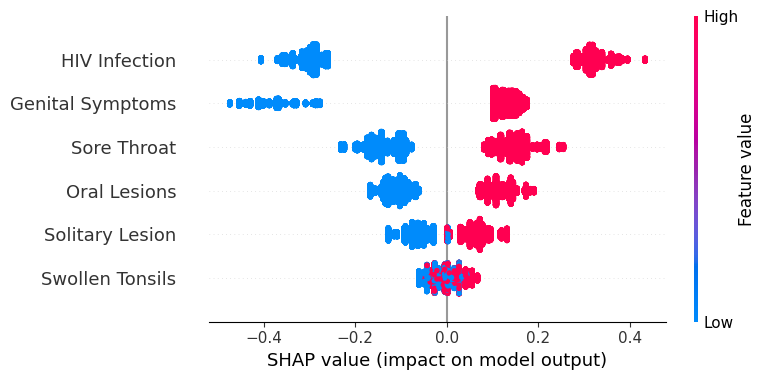

In [10]:
gb_model = models["Gradient Boosting"]

explainer = shap.TreeExplainer(gb_model)
shap_values = explainer.shap_values(X_train_scaled)

shap.summary_plot(shap_values, X_train_scaled, feature_names=features_encoded)